In [13]:
import torch, einops, pathlib, cv2, json
import numpy as np
import matplotlib.pylab as plt
from matplotlib import patches
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn.models import GCN


def preprocess_keypoints(keypoints, skeletons):
    invalid_keypoint_index = keypoints.sum(axis=-1) == 0
    invalid_vector_index = []

    for i in range(len(skeletons)):
        s, e = skeletons[i]
        if s in invalid_keypoint_index or e in invalid_keypoint_index:
            invalid_vector_index.append(i)

    vec = keypoints[skeletons[:, 1]] - keypoints[skeletons[:, 0]]
    vec /= (np.linalg.norm(vec, ord=2, axis=-1, keepdims=True) + 1e-5)
    vec[invalid_vector_index] = 0
    return vec


def preprocess_keypoints_batch(keypoints, skeletons):
    vecs = np.stack([preprocess_keypoints(kpts, sks) for kpts, sks in zip(keypoints, skeletons)])
    return vecs


class FallDetector(nn.Module):

    def __init__(self, feature_dim=32):
        super(FallDetector, self).__init__()

        self.feature_extractor = nn.Sequential(nn.Linear(19*3, feature_dim), nn.LeakyReLU(0.1), nn.Linear(feature_dim, feature_dim))
        self.norm = nn.LayerNorm(feature_dim)
        self.detector = nn.LSTM(feature_dim, feature_dim, 1, batch_first=True,)
        self.classifier = nn.Sequential(nn.Linear(feature_dim, 1), nn.Sigmoid())

    def forward(self, frames):
        frames = frames.flatten(-2, -1)
        x = self.feature_extractor(frames)
        x, (hn, cn) = self.detector(x)
        x = self.classifier(x[:, -1]).squeeze(-1)
        return x

In [112]:
model = FallDetector()

In [89]:
x = torch.randn(10, 15, 17*2)
model(x).shape

torch.Size([10, 1])

In [26]:
class URDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.data_list = self._load_data_list()

    def _load_data_list(self):
        data_list = []
        for path in pathlib.Path(self.data_dir).glob("keypoints_*.json"):
            data_list.append((path, int("fall" in path.name)))

        return data_list
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        path, fallen = self.data_list[index]
        frames = self.read_keypoints(path)
        frames = torch.tensor(frames, dtype=torch.float32)
        fallen = torch.tensor(fallen, dtype=torch.long)
        return frames, fallen
    
    def read_keypoints(self, path):
        with open(str(path)) as f:
            data = json.load(f)
            
        keypoints = np.array([kpts[0] for kpts in data["keypoints"] if len(kpts) > 0])
        keypoints += np.random.normal(loc=0, scale=(keypoints.max() - keypoints.min())/100, size=keypoints.shape)
        skeleton = np.array([sks[0] for sks in data["skeleton"] if len(sks) > 0]) - 1
        # print(keypoints.shape, skeleton.shape)
        keypoints = preprocess_keypoints_batch(keypoints, skeleton)
        return keypoints

In [23]:
dataset = URDataset("../output/UR_fall_detection2")
len(dataset)

70

In [27]:
frames = dataset[20][0]
frames.shape


139.09315490722656 0.0


torch.Size([203, 19, 3])

In [144]:
for i in range(len(dataset)):
    frames = dataset[i][0]
    print(i, frames.shape)

../output/UR_fall_detection2/keypoints_parsed_adl-10-cam0.json
0 torch.Size([299, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-22-cam0.json
1 torch.Size([32, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-23-cam0.json
2 torch.Size([99, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-33-cam0.json
3 torch.Size([135, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-26-cam0.json
4 torch.Size([95, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-37-cam0.json


/tmp/ipykernel_4020468/2088773368.py:20: RuntimeWarning: invalid value encountered in divide
  vec /= np.linalg.norm(vec, ord=2, axis=-1, keepdims=True)


5 torch.Size([230, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-05-cam0.json
6 torch.Size([110, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-26-cam0.json
7 torch.Size([38, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-25-cam0.json
8 torch.Size([110, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-32-cam0.json
9 torch.Size([121, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-27-cam0.json
10 torch.Size([100, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-12-cam0.json
11 torch.Size([108, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-06-cam0.json
12 torch.Size([83, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-01-cam0.json
13 torch.Size([139, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-20-cam0.json
14 torch.Size([107, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_fall-08-cam0.json
15 torch.Size([91, 19, 3])
../output/UR_fall_detection2/keypoints_parsed_adl-12-cam0.json
1

In [85]:
frames /= frames.max(axis=1, keepdims=True)[0]

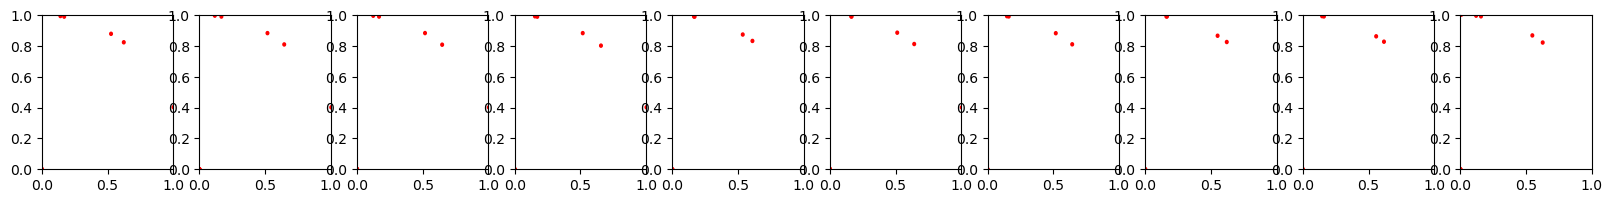

In [86]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(0, 10):
    for kp in frames[i + 27]:
        c = patches.Circle((kp[0], kp[1]), radius=0.01, fill=True, color="red")
        ax[i].add_patch(c)

plt.show()

In [28]:
model = FallDetector()
model = model.to(0)

In [ ]:
EPOCHS = 10

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.5, 0.9))
dataset = URDataset("../output/UR_fall_detection2")
dloader = DataLoader(dataset, batch_size=1, shuffle=False)

def training_step():
    for e in range(EPOCHS):
        accs = []
        gts = []
        preds = []
        for frames, labels in dloader:
            frames = frames.to(0)
            labels = labels.to(0).float()

            pred = model(frames)
            loss = criterion(pred, labels)

            cat_pred = (pred >= 0.5).float()
            acc = (labels == cat_pred).float().mean()
            accs.append(acc)
            preds.append(cat_pred.detach().cpu().numpy())
            gts.append(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        gts = np.concatenate(gts)
        preds = np.concatenate(preds)
        f1 = f1_score(gts, preds)
        acc = sum(accs) / len(accs)
        print(f"Acc: {acc:.4f}, F1: {f1:.4f}")

        if f1 > 0.9 and acc > 0.9: break


In [ ]:
training_step()

Acc: 0.5429, F1: 0.2000
Acc: 0.7143, F1: 0.5652
Acc: 0.8286, F1: 0.7778
Acc: 0.8429, F1: 0.8000
Acc: 0.8714, F1: 0.8475
Acc: 0.8714, F1: 0.8571
Acc: 0.8857, F1: 0.8667
Acc: 0.9286, F1: 0.9206


In [32]:
model = FallDetector()
model = model.to(0)

In [33]:
EPOCHS = 10

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.5, 0.9))
train_dataset = URDataset("../output/UR_fall_detection3/train")
test_dataset = URDataset("../output/UR_fall_detection3/test")
train_dloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def training_step():
    for e in range(EPOCHS):
        accs = []
        gts = []
        preds = []
        for frames, labels in train_dloader:
            frames = frames.to(0)
            labels = labels.to(0).float()

            pred = model(frames)
            loss = criterion(pred, labels)

            cat_pred = (pred >= 0.5).float()
            acc = (labels == cat_pred).float().mean()
            accs.append(acc)
            preds.append(cat_pred.detach().cpu().numpy())
            gts.append(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        gts = np.concatenate(gts)
        preds = np.concatenate(preds)
        f1 = f1_score(gts, preds)
        acc = sum(accs) / len(accs)
        print(f"(Train) Acc: {acc:.4f}, F1: {f1:.4f}")


        accs = []
        gts = []
        preds = []
        for frames, labels in test_dloader:
            frames = frames.to(0)
            labels = labels.to(0).float()

            pred = model(frames)
            loss = criterion(pred, labels)

            cat_pred = (pred >= 0.5).float()
            acc = (labels == cat_pred).float().mean()
            accs.append(acc)
            preds.append(cat_pred.detach().cpu().numpy())
            gts.append(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        gts = np.concatenate(gts)
        preds = np.concatenate(preds)
        f1 = f1_score(gts, preds)
        acc = sum(accs) / len(accs)
        print(f"(Test) Acc: {acc:.4f}, F1: {f1:.4f}")

        if f1 > 0.9 and acc > 0.9: break


In [34]:
training_step()

(Train) Acc: 0.6818, F1: 0.6818
(Test) Acc: 0.6154, F1: 0.1667
(Train) Acc: 0.8864, F1: 0.8571
(Test) Acc: 0.6538, F1: 0.4706
(Train) Acc: 0.9091, F1: 0.8889
(Test) Acc: 0.6923, F1: 0.5556
(Train) Acc: 0.9091, F1: 0.8889
(Test) Acc: 0.6923, F1: 0.5556
(Train) Acc: 0.9545, F1: 0.9474
(Test) Acc: 0.6923, F1: 0.5556
(Train) Acc: 0.9545, F1: 0.9474
(Test) Acc: 0.7692, F1: 0.7000
(Train) Acc: 0.9545, F1: 0.9474
(Test) Acc: 0.7308, F1: 0.6667
(Train) Acc: 0.9318, F1: 0.9189
(Test) Acc: 0.8462, F1: 0.8182
(Train) Acc: 0.9318, F1: 0.9189
(Test) Acc: 0.8077, F1: 0.7619
(Train) Acc: 0.9318, F1: 0.9189
(Test) Acc: 0.8846, F1: 0.8421


In [26]:
import os
for path in pathlib.Path("../output/UR_fall_detection2/").glob("keypoints*"):
    os.rename(str(path), str(path).replace(".txt", ".json"))